In [1]:
import pandas as pd
import numpy as np
import re


In [2]:
def cleanup_hive_message(mess):
    if('TExecuteStatementResp' in mess):
        mess1 = re.sub('^(.*)infoMessages=\[' , '' , mess)
        mess2 = mess1.split(':')
        # print("HIVE_BEFORE" , mess)
        # print("HIVE_AFTER" , mess2)
        res = mess2[1] + " " +mess2[2] + " " +mess2[3]
        # print("HIVE_AFTER2" , res)
        return res
    return mess


def read_bad_csv_file(name):
    rows = [];
    with open(name) as f:
        content = f.readlines()
    for line in content:
        line1 = line.replace("cx_" , "cx+")
        line1 = line1.replace("\n" , "")
        line1 = line1.replace("DataError" , "OperationalError")
        line1 = line1.replace("ProgrammingError" , "OperationalError")
        
        # line1 = re.sub('SQL.*$' , '',  line1)
        sql_error = ""
        
        if('Operational' in line1):
            #print("LINE1_BEFORE" , line1)
            if("[SQL" in line1):
                line1 = re.sub('OperationalError:.*OperationalError(.*)\[SQL.*$' , '____SQLERROR__\g<1>__SQLERROR____',  line1)
            else:
                line1 = re.sub('OperationalError:.*OperationalError(.*).*$' , '____SQLERROR__\g<1>__SQLERROR____',  line1)
                
            #print("LINE1_AFTER" , line1)
            sql_error = re.sub('.*____SQLERROR__', '',  line1)
            sql_error = re.sub('__SQLERROR____.*', '',  sql_error)
            sql_error = sql_error.replace(") (" , "")
            sql_error = sql_error.replace("\\n" , "")
            sql_error = sql_error.replace("\\" , "")
            sql_error = sql_error[:-2]
            #print("LINE1_AFTER" , sql_error)
        
        # line1 = re.sub('COMPARISON_FAILURE_TOO_MUCH_DIFFS.*$' , 'COMPARISON_FAILURE_TOO_MUCH_DIFFS',  line1)
        # line1 = re.sub('Table .* doesn.*$' , "Table doesn't exist",  line1)
        
        lRegex  = '\s+'
        fields = re.split(lRegex, line1);

        # print(fields)
        # for (i,f) in enumerate(fields):
        #    print(i, f)
        msg_field = " ".join(fields[11:12])
        if(sql_error != ""):
            msg_field = sql_error
        time_field = fields[-1].replace(")" , "")
        row = [fields[1], fields[2], fields[4], fields[3], fields[10], msg_field, time_field]
        rows = rows + [row]

    df = pd.DataFrame(rows);
    df.columns = ['Model' , 'dataset', 'est_dialect' , 'DSN' , 'status' , 'error_message' , 'elapsed_time']
    df['Model'] = df['Model'].str.replace("\(\'" , "")
    df['Model'] = df['Model'].str.replace("\'," , "")
    df['error_message'] = df['error_message'].str.replace("None\)\)" , "SUCCESS")
    df['error_message'] = df['error_message'].str.replace("None\)," , "SUCCESS")
    df['error_message'] = df['error_message'].apply(lambda x : cleanup_hive_message(x))
    return df
    

In [3]:
#df = pd.read_csv('result.txt' , engine='python', sep='\s+', index_col=False,
#                 quotechar="'", header=None)

In [4]:
df = read_bad_csv_file('result.txt')

In [5]:
df.head()

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time
0,LGBMClassifier,"'DS_BENCH_200_22_0_1__0_1_DB7350D0',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,19
1,LGBMClassifier,"'DS_BENCH_200_22_0_1__2_3_DB7350D0',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,19
2,LGBMClassifier,"'DS_BENCH_200_22_0_1__8_9_DB7350D0',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,19
3,LGBMClassifier,"'DS_BENCH_200_7_0_1__0_1_27D91BF6',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,19
4,LGBMClassifier,"'DS_BENCH_200_7_0_1__2_3_27D91BF6',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,19


In [6]:
# df.elapsed_time.value_counts()

In [7]:
def read_classes(name):
    lClasses = {}
    lCategories = {}
    rows = [];
    with open(name) as f:
        content = f.readlines()
    for line in content:
        line1 = line.replace("cGenerationWrapperFactory::createScikitObject() <class '" , "")
        line1 = line1.replace("'>\n" , "")
        fq_class_name = line1
        short_class_name = fq_class_name.split(".")[-1]
        categeory = ".".join(fq_class_name.split(".")[0:2])
        lClasses[short_class_name] = fq_class_name
        lCategories[short_class_name] = categeory
    return (lClasses , lCategories)


In [8]:
(Classes , Categories) = read_classes("classes.txt")

In [9]:
Classes

{'ARDRegression': 'sklearn.linear_model.bayes.ARDRegression',
 'AdaBoostClassifier': 'sklearn.ensemble.weight_boosting.AdaBoostClassifier',
 'AdaBoostRegressor': 'sklearn.ensemble.weight_boosting.AdaBoostRegressor',
 'BaggingClassifier': 'sklearn.ensemble.bagging.BaggingClassifier',
 'BaggingRegressor': 'sklearn.ensemble.bagging.BaggingRegressor',
 'BayesianRidge': 'sklearn.linear_model.bayes.BayesianRidge',
 'BernoulliNB': 'sklearn.naive_bayes.BernoulliNB',
 'Binarizer': 'sklearn.preprocessing.data.Binarizer',
 'CalibratedClassifierCV': 'sklearn.calibration.CalibratedClassifierCV',
 'DecisionTreeClassifier': 'sklearn.tree.tree.DecisionTreeClassifier',
 'DecisionTreeRegressor': 'sklearn.tree.tree.DecisionTreeRegressor',
 'DummyClassifier': 'sklearn.dummy.DummyClassifier',
 'DummyRegressor': 'sklearn.dummy.DummyRegressor',
 'ElasticNet': 'sklearn.linear_model.coordinate_descent.ElasticNet',
 'ElasticNetCV': 'sklearn.linear_model.coordinate_descent.ElasticNetCV',
 'EllipticEnvelope': 'sk

In [10]:
def get_category(model_name):
    real_name = model_name
    if(model_name.endswith('_pipe')):
        real_name = model_name.replace("_pipe" , "")
    return Categories.get(real_name , "bad_category")

df['model_category'] = df['Model'].apply(get_category)
df.head()


,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category
0,LGBMClassifier,"'DS_BENCH_200_22_0_1__0_1_DB7350D0',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,19,lightgbm.sklearn
1,LGBMClassifier,"'DS_BENCH_200_22_0_1__2_3_DB7350D0',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,19,lightgbm.sklearn
2,LGBMClassifier,"'DS_BENCH_200_22_0_1__8_9_DB7350D0',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,19,lightgbm.sklearn
3,LGBMClassifier,"'DS_BENCH_200_7_0_1__0_1_27D91BF6',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,19,lightgbm.sklearn
4,LGBMClassifier,"'DS_BENCH_200_7_0_1__2_3_27D91BF6',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,19,lightgbm.sklearn


In [11]:
df_model_datasets = pd.DataFrame(df[['Model' , 'dataset']].groupby(['Model'])['dataset'].value_counts())
datatsets_by_model = df_model_datasets.to_dict()['dataset'].keys()

In [12]:
# datatsets_by_model

In [13]:
datatsets_by_model_dict = {}
for k in datatsets_by_model:
    (m , ds) = k
    if(m not in datatsets_by_model_dict.keys()):
        datatsets_by_model_dict[m] = [ds]
    else:
        datatsets_by_model_dict[m] = datatsets_by_model_dict[m] + [ds]
        
# print(datatsets_by_model_dict)


In [14]:
missing_rows = []
dialects = df.est_dialect.unique()
print(dialects)

print("df.shape", df.shape , df.columns)
for dialect in dialects:
    df1 = df[df['est_dialect'] == dialect]
    # print("df1.shape", dialect, df1.shape , df1.columns)
    for (m , datasets) in datatsets_by_model_dict.items():
        lMissing = 0
        cond2 = (df1['Model'] == m)
        df2 = df1[cond2]
        # print("df2.shape", dialect, m , df2.shape, df2.columns)
        for ds in datasets:
            cond3 = (df2['dataset'] == ds)
            df3 = df2[cond3]
            # print("df3.shape", dialect, m, ds, df3.shape, df3.columns)
            if(df3.shape[0] == 0):
                # print("MISSING_DATA" , [dialect , m , ds])
                missing_rows = missing_rows + [[m , ds, dialect , 'no_dsn' , 'failure' , 'TIMEOUT' , 300, get_category(m)]]
                lMissing = lMissing + 1
        if(lMissing >= (len(datasets) // 2)):
            print("MODEL_DATASETS_MISSING" , dialect, m, len(datasets) , lMissing)

missing_data = pd.DataFrame(missing_rows, columns=df.columns)
# missing_data

["'db2'," "'firebird'," "'impala'," "'monetdb'," "'mssql'," "'mysql',"
 "'oracle'," "'pgsql'," "'sqltm'," "'teradata',"]
df.shape (19643, 8) Index(['Model', 'dataset', 'est_dialect', 'DSN', 'status', 'error_message',
       'elapsed_time', 'model_category'],
      dtype='object')
MODEL_DATASETS_MISSING 'db2', MLPClassifier_pipe 18 18
MODEL_DATASETS_MISSING 'db2', Perceptron_pipe 18 18
MODEL_DATASETS_MISSING 'db2', RANSACRegressor 2 2
MODEL_DATASETS_MISSING 'firebird', AdaBoostClassifier_pipe 18 10
MODEL_DATASETS_MISSING 'firebird', BaggingClassifier_pipe 18 12
MODEL_DATASETS_MISSING 'firebird', ExtraTreesClassifier_pipe 18 12
MODEL_DATASETS_MISSING 'firebird', GradientBoostingClassifier_pipe 18 14
MODEL_DATASETS_MISSING 'firebird', LGBMClassifier_pipe 18 16
MODEL_DATASETS_MISSING 'firebird', LinearDiscriminantAnalysis_pipe 18 18
MODEL_DATASETS_MISSING 'firebird', LogisticRegressionCV_pipe 18 18
MODEL_DATASETS_MISSING 'firebird', LogisticRegression_pipe 18 18
MODEL_DATASETS_MISSING 'fir

In [15]:
missing_data.head()

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category
0,MLPClassifier_pipe,"'p_DS_BENCH_50_22_0_1__0_1_DB7350D0',","'db2',",no_dsn,failure,TIMEOUT,300,sklearn.neural_network
1,MLPClassifier_pipe,"'p_DS_BENCH_50_22_0_1__2_3_DB7350D0',","'db2',",no_dsn,failure,TIMEOUT,300,sklearn.neural_network
2,MLPClassifier_pipe,"'p_DS_BENCH_50_22_0_1__8_9_DB7350D0',","'db2',",no_dsn,failure,TIMEOUT,300,sklearn.neural_network
3,MLPClassifier_pipe,"'p_DS_BENCH_50_7_0_1__0_1_27D91BF6',","'db2',",no_dsn,failure,TIMEOUT,300,sklearn.neural_network
4,MLPClassifier_pipe,"'p_DS_BENCH_50_7_0_1__2_3_27D91BF6',","'db2',",no_dsn,failure,TIMEOUT,300,sklearn.neural_network


In [16]:
df = df.append(missing_data , ignore_index=True)

In [17]:
df[df.error_message == "'"].head(200)

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category


In [18]:
df.shape

(20480, 8)

In [19]:
df.est_dialect.value_counts()

'firebird',    2048
'monetdb',     2048
'sqltm',       2048
'teradata',    2048
'mssql',       2048
'mysql',       2048
'impala',      2048
'oracle',      2048
'db2',         2048
'pgsql',       2048
Name: est_dialect, dtype: int64

In [20]:
#df0[df0.ds == numpy.na]
df_errors = df[(df.error_message != 'SUCCESS')]
indices = df_errors.error_message.apply(lambda x : 'dialect' not in x)
df_errors = df_errors[indices]


In [21]:
msg_by_estim_and_dsn = pd.DataFrame(df_errors.groupby(['est_dialect'])['error_message'].value_counts())

In [22]:
msg_by_estim_and_dsn.sort_values(by='error_message' , ascending=False)

error_message
est_dialect error_message                                                    
'impala',   "DBAPIError:(impala.error.HiveServer2Error)                   275
'firebird', TIMEOUT                                                       233
            'DatabaseError:(fdb.fbcore.DatabaseError)                     223
'monetdb',  TIMEOUT                                                       142
'sqltm',    TIMEOUT                                                        92
'db2',      "Exception:CODE_GENERATION_NOT_IMPLEMENTED                     90
'teradata', "Exception:CODE_GENERATION_NOT_IMPLEMENTED                     90
'sqltm',    "Exception:CODE_GENERATION_NOT_IMPLEMENTED                     90
'pgsql',    "Exception:CODE_GENERATION_NOT_IMPLEMENTED                     90
'oracle',   "Exception:CODE_GENERATION_NOT_IMPLEMENTED                     90
'mysql',    "Exception:CODE_GENERATION_NOT_IMPLEMENTED                     90
'monetdb',  "Exception:CODE_GENERATION_NOT_IMPLEMENTED                     90
'impala',   "Exception:CODE_GENERATION_NOT_IMPLEMENTED                     90
'firebird', "Exception:CODE_GENERATION_NOT_IMPLEMENTED                     90
'mssql',    "Exception:CODE_GENERATION_NOT_IMPLEMENTED                     90
'mysql',    "InternalError:(_mysql_exceptions.InternalError)               85
'teradata', TIMEOUT                                                        84
'pgsql',    TIMEOUT                                                        74
'monetdb',  "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   74
'mysql',    TIMEOUT                                                        74
'teradata', "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   71
'mssql',    "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   67
'mysql',    "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   64
'monetdb',  "DatabaseError:(pymonetdb.exceptions.DatabaseEr...             63
'oracle',   "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   61
'teradata', 'DatabaseError:(teradata.api.DatabaseError)                    61
'pgsql',    "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   61
'db2',      "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   61
'impala',   "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   58
            TIMEOUT                                                        55
...                                                                       ...
'monetdb',  ) Math exception: Numerical result out of rang                  6
'db2',      : SQLNumResultCols failed: [IBM][CLI Driver][DB...              6
            'DBAPIError:(ibm_db_dbi.Error)                                  6
'sqltm',    ) too many columns in result se                                 6
            ) too many terms in compound SELEC                              6
'mssql',    TIMEOUT                                                         5
'monetdb',  'DBAPIError:(builtins.BrokenPipeError)                          3
'pgsql',    ) stack depth limit exceededHINT:  Increase the...              2
'mssql',    8631, b'Internal error: Server stack limit has ...              2
'db2',      'InternalError:(ibm_db_dbi.InternalError)                       2
'mysql',    1436, "Thread stack overrun:  1237888 bytes use...              2
'db2',      : Statement Execute Failed: [IBM][CLI Driver][D...              2
'sqltm',    ) Expression tree is too large (maximum depth 1000              2
'db2',      : Statement Execute Failed: [IBM][CLI Driver][D...              1
'oracle',   'DatabaseError:(cx+Oracle.DatabaseError)                        1
'db2',      : Statement Execute Failed: [IBM][CLI Driver][D...              1
'mssql',    2714, b"There is already an object named '##TMP...              1
            2714, b"There is already an object named '##TMP...              1
            2714, b"There is already an object named '##TMP...              1
'db2',  

In [23]:
pd.DataFrame(df.error_message.value_counts())

,error_message
SUCCESS,17310
"""Exception:CODE_GENERATION_NOT_IMPLEMENTED",900
TIMEOUT,837
"""Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS",601
"""DBAPIError:(impala.error.HiveServer2Error)",275
'DatabaseError:(fdb.fbcore.DatabaseError),223
"""InternalError:(_mysql_exceptions.InternalError)",85
"""DatabaseError:(pymonetdb.exceptions.DatabaseError)",63
'DatabaseError:(teradata.api.DatabaseError),61
"""DatabaseError:(fdb.fbcore.DatabaseError)",18


In [24]:

lGroupBy = df[df.status == 'failure'].groupby(['error_message'])

In [25]:
#lGroupBy['rows'].describe()

In [26]:
real_errors = df[df.error_message == '"Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS']

In [27]:
real_errors.Model.value_counts()

DummyClassifier                180
DummyClassifier_pipe           158
IsolationForest_pipe            54
IsolationForest                 54
NuSVC_pipe                      42
OneVsRestClassifier             27
FastICA                         27
FactorAnalysis                  18
Lars                             8
ExtraTreesClassifier_pipe        7
ExtraTreesClassifier             7
MultinomialNB                    3
AdaBoostClassifier_pipe          3
RandomForestClassifier_pipe      3
AdaBoostClassifier               3
BernoulliNB                      3
OneVsRestClassifier_pipe         3
EllipticEnvelope                 1
Name: Model, dtype: int64

In [28]:
lNotImplementedMessage = '"Exception:CODE_GENERATION_NOT_IMPLEMENTED'
not_impl_errors = df[df.error_message == lNotImplementedMessage]
not_impl_errors.Model.value_counts()

KernelPCA                    180
NMF                          180
MiniBatchSparsePCA           180
LatentDirichletAllocation    180
SparsePCA                    180
Name: Model, dtype: int64

In [29]:
# df.pivot(index = 'Model', values='status' , columns='est_dialect')

In [30]:
df.columns

Index(['Model', 'dataset', 'est_dialect', 'DSN', 'status', 'error_message',
       'elapsed_time', 'model_category'],
      dtype='object')

In [31]:
df.head()

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category
0,LGBMClassifier,"'DS_BENCH_200_22_0_1__0_1_DB7350D0',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,19,lightgbm.sklearn
1,LGBMClassifier,"'DS_BENCH_200_22_0_1__2_3_DB7350D0',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,19,lightgbm.sklearn
2,LGBMClassifier,"'DS_BENCH_200_22_0_1__8_9_DB7350D0',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,19,lightgbm.sklearn
3,LGBMClassifier,"'DS_BENCH_200_7_0_1__0_1_27D91BF6',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,19,lightgbm.sklearn
4,LGBMClassifier,"'DS_BENCH_200_7_0_1__2_3_27D91BF6',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,19,lightgbm.sklearn


In [32]:
df['status'] = df['status'].apply(lambda x : 1 if('failure' in x) else 0)
df['status_2'] = df['status'].apply(lambda x : 1)


In [33]:
def strip_punc(x):
    x = x .replace("'" , "")
    x = x .replace("(" , "")
    x = x .replace("," , "")
    return x

df['dialect'] = df['est_dialect'].apply(lambda x : strip_punc(x))
df['Model'] = df['Model'].apply(lambda x : strip_punc(x))
df['dataset'] = df['dataset'].apply(lambda x : strip_punc(x))
df = df[df['model_category'] != 'sklearn.dummy']
df = df[df['error_message'] != lNotImplementedMessage]



In [34]:
df.head()

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category,status_2,dialect
0,LGBMClassifier,DS_BENCH_200_22_0_1__0_1_DB7350D0,"'db2',","'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,19,lightgbm.sklearn,1,db2
1,LGBMClassifier,DS_BENCH_200_22_0_1__2_3_DB7350D0,"'db2',","'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,19,lightgbm.sklearn,1,db2
2,LGBMClassifier,DS_BENCH_200_22_0_1__8_9_DB7350D0,"'db2',","'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,19,lightgbm.sklearn,1,db2
3,LGBMClassifier,DS_BENCH_200_7_0_1__0_1_27D91BF6,"'db2',","'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,19,lightgbm.sklearn,1,db2
4,LGBMClassifier,DS_BENCH_200_7_0_1__2_3_27D91BF6,"'db2',","'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,19,lightgbm.sklearn,1,db2


In [35]:
# How many tests were used for each model category
pvt_count = pd.pivot_table(df, index='model_category', values='status_2' , columns=['dialect'],  aggfunc=[np.sum], margins=True)
pvt_count.head(pvt_count.shape[0])


sum                                      \
dialect                         db2 firebird impala monetdb mssql mysql   
model_category                                                            
lightgbm.sklearn                 48       48     48      48    48    48   
sklearn.calibration              36       36     36      36    36    36   
sklearn.covariance               12       12     12      12    12    12   
sklearn.decomposition            90       90     90      90    90    90   
sklearn.discriminant_analysis    36       36     36      36    36    36   
sklearn.ensemble                252      252    252     252   252   252   
sklearn.feature_selection       162      162    162     162   162   162   
sklearn.kernel_ridge             12       12     12      12    12    12   
sklearn.linear_model            482      482    482     482   482   482   
sklearn.multiclass               72       72     72      72    72    72   
sklearn.naive_bayes              90       90     90      90    90    90   
sklearn.neural_network           48       48     48      48    48    48   
sklearn.pipeline                 54       54     54      54    54    54   
sklearn.preprocessing           216      216    216     216   216   216   
sklearn.svm                     156      156    156     156   156   156   
sklearn.tree                     96       96     96      96    96    96   
xgboost.sklearn                  48       48     48      48    48    48   
All                            1910     1910   1910    1910  1910  1910   

                                                                  
dialect                       oracle pgsql sqltm teradata    All  
model_category                                                    
lightgbm.sklearn                  48    48    48       48    480  
sklearn.calibration               36    36    36       36    360  
sklearn.covariance                12    12    12       12    120  
sklearn.decomposition             90    90    90       90    900  
sklearn.discriminant_analysis     36    36    36       36    360  
sklearn.ensemble                 252   252   252      252   2520  
sklearn.feature_selection        162   162   162      162   1620  
sklearn.kernel_ridge              12    12    12       12    120  
sklearn.linear_model             482   482   482      482   4820  
sklearn.multiclass                72    72    72       72    720  
sklearn.naive_bayes               90    90    90       90    900  
sklearn.neural_network            48    48    48       48    480  
sklearn.pipeline                  54    54    54       54    540  
sklearn.preprocessing            216   216   216      216   2160  
sklearn.svm                      156   156   156      156   1560  
sklearn.tree                      96    96    96       96    960  
xgboost.sklearn                   48    48    48       48    480  
All                             1910  1910  1910     1910  19100

In [36]:
pvt = pd.pivot_table(df, index='model_category', values='status' , columns=['dialect'],  aggfunc=[np.mean], margins=True)

In [37]:
pvt.head(pvt.shape[0])

mean                                \
dialect                             db2  firebird    impala   monetdb   
model_category                                                          
lightgbm.sklearn               0.000000  0.416667  0.020833  0.000000   
sklearn.calibration            0.000000  0.194444  0.000000  0.722222   
sklearn.covariance             0.166667  0.166667  0.166667  0.666667   
sklearn.decomposition          0.033333  0.100000  0.033333  0.244444   
sklearn.discriminant_analysis  0.000000  0.583333  0.500000  0.000000   
sklearn.ensemble               0.051587  0.396825  0.063492  0.047619   
sklearn.feature_selection      0.000000  0.000000  0.000000  0.000000   
sklearn.kernel_ridge           0.000000  0.583333  0.000000  0.000000   
sklearn.linear_model           0.045643  0.105809  0.458506  0.004149   
sklearn.multiclass             0.041667  0.708333  0.069444  0.041667   
sklearn.naive_bayes            0.066667  1.000000  0.988889  0.622222   
sklearn.neural_network         0.375000  0.250000  0.000000  0.000000   
sklearn.pipeline               0.000000  0.000000  0.000000  0.000000   
sklearn.preprocessing          0.055556  0.083333  0.055556  0.050926   
sklearn.svm                    0.044872  0.448718  0.038462  0.711538   
sklearn.tree                   0.031250  0.052083  0.000000  0.000000   
xgboost.sklearn                0.020833  0.333333  0.000000  0.020833   
All                            0.047120  0.250785  0.195288  0.131937   

                                                                       \
dialect                           mssql     mysql    oracle     pgsql   
model_category                                                          
lightgbm.sklearn               0.020833  0.000000  0.125000  0.000000   
sklearn.calibration            0.000000  0.000000  0.000000  0.000000   
sklearn.covariance             0.166667  0.166667  0.666667  0.166667   
sklearn.decomposition          0.033333  0.033333  0.033333  0.033333   
sklearn.discriminant_analysis  0.000000  0.000000  0.000000  0.000000   
sklearn.ensemble               0.047619  0.047619  0.119048  0.119048   
sklearn.feature_selection      0.000000  0.000000  0.000000  0.000000   
sklearn.kernel_ridge           0.000000  0.000000  0.000000  0.000000   
sklearn.linear_model           0.008299  0.118257  0.006224  0.006224   
sklearn.multiclass             0.055556  0.111111  0.041667  0.541667   
sklearn.naive_bayes            0.233333  0.922222  0.000000  0.066667   
sklearn.neural_network         0.020833  0.000000  0.000000  0.000000   
sklearn.pipeline               0.000000  0.000000  0.000000  0.000000   
sklearn.preprocessing          0.000000  0.000000  0.000000  0.027778   
sklearn.svm                    0.038462  0.038462  0.038462  0.038462   
sklearn.tree                   0.000000  0.187500  0.000000  0.187500   
xgboost.sklearn                0.000000  0.000000  0.020833  0.000000   
All                            0.028272  0.098953  0.031414  0.059162   

                                                             
dialect                           sqltm  teradata       All  
model_category                                               
lightgbm.sklearn               0.000000  0.062500  0.064583  
sklearn.calibration            0.500000  0.000000  0.141667  
sklearn.covariance             0.166667  0.166667  0.266667  
sklearn.decomposition          0.033333  0.033333  0.061111  
sklearn.discriminant_analysis  0.000000  0.000000  0.108333  
sklearn.ensemble               0.047619  0.138889  0.107937  
sklearn.feature_selection      0.000000  0.000000  0.000000  
sklearn.kernel_ridge           0.000000  0.000000  0.058333  
sklearn.linear_model           0.006224  0.043568  0.080290  
sklearn.multiclass             0.291667  0.041667  0.194444  
sklearn.naive_bayes            0.000000  0.855556  0.475556  
sklearn.neural_network         0.375000  0.000000  0.102083  
sklearn.pipeline               0.3333

In [38]:
df.to_csv('report_extensive_tests.csv')

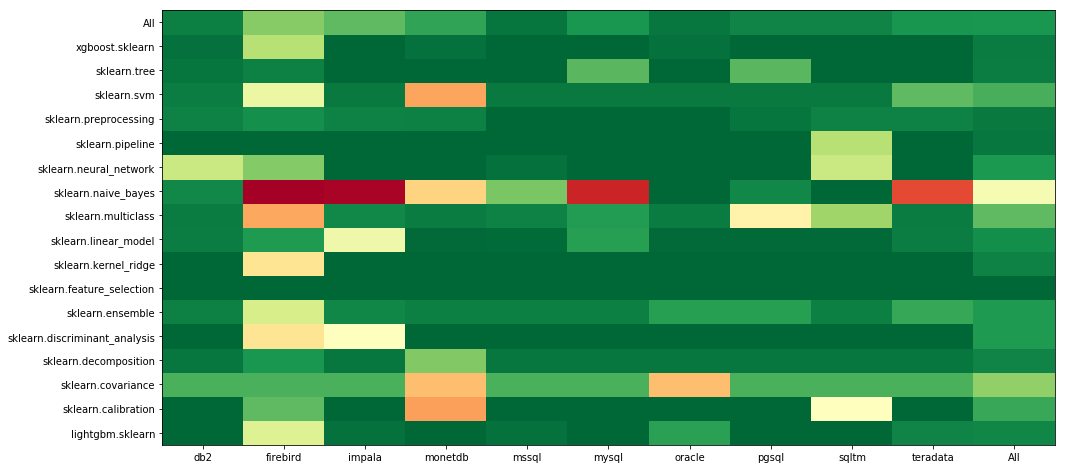

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.pcolor(1-pvt, cmap='RdYlGn')
plt.yticks(np.arange(0.5, len(pvt.index), 1), pvt.index)
plt.xticks(np.arange(0.5, len(pvt.columns), 1), [col[1] for col in pvt.columns])
fig = plt.gcf()
fig.set_size_inches(16, 8)

plt.show()       
    

In [40]:
Category_Labels = df.model_category.unique()


In [41]:
Category_Labels

array(['lightgbm.sklearn', 'sklearn.calibration', 'sklearn.covariance',
       'sklearn.decomposition', 'sklearn.discriminant_analysis',
       'sklearn.ensemble', 'sklearn.feature_selection',
       'sklearn.kernel_ridge', 'sklearn.linear_model',
       'sklearn.multiclass', 'sklearn.naive_bayes',
       'sklearn.neural_network', 'sklearn.pipeline',
       'sklearn.preprocessing', 'sklearn.svm', 'sklearn.tree',
       'xgboost.sklearn'], dtype=object)

In [42]:





for cat in Category_Labels:
    print("ERROR_REPORT_FOR_CATEGORY" , cat)
    df1 = df[df.model_category == cat]
    real_errors = df1 # df1[df1.error_message != "SUCCESS"]
    if(real_errors.shape[0] > 0):
        msg_by_estim_and_dsn = pd.DataFrame(real_errors.groupby(['est_dialect'])['error_message'].value_counts())
        from IPython.core.display import display, HTML
        display(msg_by_estim_and_dsn)
        pvt1 = pd.pivot_table(df1, index='Model', values='status' , columns=['dialect'],  aggfunc=[np.mean], margins=True)
        display(pvt1)
    else:
        print("NO_ERROR_FOR_CATEGORY" , cat)
    

ERROR_REPORT_FOR_CATEGORY lightgbm.sklearn


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                        48
'firebird', SUCCESS                                                        28
            TIMEOUT                                                        16
            'DatabaseError:(fdb.fbcore.DatabaseError)                       4
'impala',   SUCCESS                                                        47
            'DBAPIError:(impala.error.HiveServer2Error)                     1
'monetdb',  SUCCESS                                                        48
'mssql',    SUCCESS                                                        47
            2714, b"There is already an object named '##TMP...              1
'mysql',    SUCCESS                                                        48
'oracle',   SUCCESS                                                        42
            TIMEOUT                                                         6
'pgsql',    SUCCESS                                                        48
'sqltm',    SUCCESS                                                        48
'teradata', SUCCESS                                                        45
            'DatabaseError:(teradata.api.DatabaseError)                     3

mean                                                     \
dialect              db2  firebird    impala monetdb     mssql mysql oracle   
Model                                                                         
LGBMClassifier       0.0  0.166667  0.055556     0.0  0.000000   0.0  0.000   
LGBMClassifier_pipe  0.0  0.888889  0.000000     0.0  0.055556   0.0  0.000   
LGBMRegressor        0.0  0.166667  0.000000     0.0  0.000000   0.0  0.000   
LGBMRegressor_pipe   0.0  0.000000  0.000000     0.0  0.000000   0.0  1.000   
All                  0.0  0.416667  0.020833     0.0  0.020833   0.0  0.125   

                                                     
dialect             pgsql sqltm  teradata       All  
Model                                                
LGBMClassifier        0.0   0.0  0.000000  0.022222  
LGBMClassifier_pipe   0.0   0.0  0.166667  0.111111  
LGBMRegressor         0.0   0.0  0.000000  0.016667  
LGBMRegressor_pipe    0.0   0.0  0.000000  0.100000  
All                   0.0   0.0  0.062500  0.064583

ERROR_REPORT_FOR_CATEGORY sklearn.calibration


error_message
est_dialect error_message               
'db2',      SUCCESS                   36
'firebird', SUCCESS                   29
            TIMEOUT                    7
'impala',   SUCCESS                   36
'monetdb',  TIMEOUT                   26
            SUCCESS                   10
'mssql',    SUCCESS                   36
'mysql',    SUCCESS                   36
'oracle',   SUCCESS                   36
'pgsql',    SUCCESS                   36
'sqltm',    SUCCESS                   18
            TIMEOUT                   18
'teradata', SUCCESS                   36

mean                                         \
dialect                      db2  firebird impala   monetdb mssql mysql   
Model                                                                     
CalibratedClassifierCV       0.0  0.000000    0.0  0.444444   0.0   0.0   
CalibratedClassifierCV_pipe  0.0  0.388889    0.0  1.000000   0.0   0.0   
All                          0.0  0.194444    0.0  0.722222   0.0   0.0   

                                                                   
dialect                     oracle pgsql sqltm teradata       All  
Model                                                              
CalibratedClassifierCV         0.0   0.0   0.0      0.0  0.044444  
CalibratedClassifierCV_pipe    0.0   0.0   1.0      0.0  0.238889  
All                            0.0   0.0   0.5      0.0  0.141667

ERROR_REPORT_FOR_CATEGORY sklearn.covariance


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                        10
            'InternalError:(ibm_db_dbi.InternalError)                       2
'firebird', SUCCESS                                                        10
            'DatabaseError:(fdb.fbcore.DatabaseError)                       2
'impala',   SUCCESS                                                        10
            "DBAPIError:(impala.error.HiveServer2Error)                     2
'monetdb',  TIMEOUT                                                         7
            SUCCESS                                                         4
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
'mssql',    SUCCESS                                                        10
            8631, b'Internal error: Server stack limit has ...              2
'mysql',    SUCCESS                                                        10
            1436, "Thread stack overrun:  1237888 bytes use...              2
'oracle',   TIMEOUT                                                         8
            SUCCESS                                                         4
'pgsql',    SUCCESS                                                        10
            ) stack depth limit exceededHINT:  Increase the...              2
'sqltm',    SUCCESS                                                        10
            ) Expression tree is too large (maximum depth 1000              2
'teradata', SUCCESS                                                        10
            'DatabaseError:(teradata.api.DatabaseError)                     2

mean                                          \
dialect                     db2  firebird    impala   monetdb     mssql   
Model                                                                     
EllipticEnvelope       0.333333  0.333333  0.333333  0.333333  0.333333   
EllipticEnvelope_pipe  0.000000  0.000000  0.000000  1.000000  0.000000   
All                    0.166667  0.166667  0.166667  0.666667  0.166667   

                                                                         \
dialect                   mysql    oracle     pgsql     sqltm  teradata   
Model                                                                     
EllipticEnvelope       0.333333  0.333333  0.333333  0.333333  0.333333   
EllipticEnvelope_pipe  0.000000  1.000000  0.000000  0.000000  0.000000   
All                    0.166667  0.666667  0.166667  0.166667  0.166667   

                                 
dialect                     All  
Model                            
EllipticEnvelope       0.333333  
EllipticEnvelope_pipe  0.200000  
All                    0.266667

ERROR_REPORT_FOR_CATEGORY sklearn.decomposition


error_message
est_dialect error_message                                              
'db2',      SUCCESS                                                  87
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3
'firebird', SUCCESS                                                  81
            'DatabaseError:(fdb.fbcore.DatabaseError)                 6
            "DatabaseError:(fdb.fbcore.DatabaseError)                 3
'impala',   SUCCESS                                                  87
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3
'monetdb',  SUCCESS                                                  68
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             21
            TIMEOUT                                                   1
'mssql',    SUCCESS                                                  87
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3
'mysql',    SUCCESS                                                  87
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3
'oracle',   SUCCESS                                                  87
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3
'pgsql',    SUCCESS                                                  87
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3
'sqltm',    SUCCESS                                                  87
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3
'teradata', SUCCESS                                                  87
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3

mean                                                    \
dialect              db2  firebird    impala   monetdb     mssql     mysql   
Model                                                                        
FactorAnalysis  0.000000  0.000000  0.000000  1.000000  0.000000  0.000000   
FastICA         0.166667  0.333333  0.166667  0.222222  0.166667  0.166667   
IncrementalPCA  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
PCA             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
TruncatedSVD    0.000000  0.166667  0.000000  0.000000  0.000000  0.000000   
All             0.033333  0.100000  0.033333  0.244444  0.033333  0.033333   

                                                                  
dialect           oracle     pgsql     sqltm  teradata       All  
Model                                                             
FactorAnalysis  0.000000  0.000000  0.000000  0.000000  0.100000  
FastICA         0.166667  0.166667  0.166667  0.166667  0.188889  
IncrementalPCA  0.000000  0.000000  0.000000  0.000000  0.000000  
PCA             0.000000  0.000000  0.000000  0.000000  0.000000  
TruncatedSVD    0.000000  0.000000  0.000000  0.000000  0.016667  
All             0.033333  0.033333  0.033333  0.033333  0.061111

ERROR_REPORT_FOR_CATEGORY sklearn.discriminant_analysis


error_message
est_dialect error_message                                             
'db2',      SUCCESS                                                 36
'firebird', TIMEOUT                                                 21
            SUCCESS                                                 15
'impala',   "DBAPIError:(impala.error.HiveServer2Error)             18
            SUCCESS                                                 18
'monetdb',  SUCCESS                                                 36
'mssql',    SUCCESS                                                 36
'mysql',    SUCCESS                                                 36
'oracle',   SUCCESS                                                 36
'pgsql',    SUCCESS                                                 36
'sqltm',    SUCCESS                                                 36
'teradata', SUCCESS                                                 36

mean                                       \
dialect                          db2  firebird impala monetdb mssql mysql   
Model                                                                       
LinearDiscriminantAnalysis       0.0  0.166667    1.0     0.0   0.0   0.0   
LinearDiscriminantAnalysis_pipe  0.0  1.000000    0.0     0.0   0.0   0.0   
All                              0.0  0.583333    0.5     0.0   0.0   0.0   

                                                                       
dialect                         oracle pgsql sqltm teradata       All  
Model                                                                  
LinearDiscriminantAnalysis         0.0   0.0   0.0      0.0  0.116667  
LinearDiscriminantAnalysis_pipe    0.0   0.0   0.0      0.0  0.100000  
All                                0.0   0.0   0.0      0.0  0.108333

ERROR_REPORT_FOR_CATEGORY sklearn.ensemble


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                       239
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   12
            : Statement Execute Failed: [IBM][CLI Driver][D...              1
'firebird', SUCCESS                                                       152
            TIMEOUT                                                        61
            'DatabaseError:(fdb.fbcore.DatabaseError)                      33
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    6
'impala',   SUCCESS                                                       236
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   12
            'DBAPIError:(impala.error.HiveServer2Error)                     3
            ) TableNotFoundException: Table not found: impa...              1
'monetdb',  SUCCESS                                                       240
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   12
'mssql',    SUCCESS                                                       240
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   12
'mysql',    SUCCESS                                                       240
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   12
'oracle',   SUCCESS                                                       222
            TIMEOUT                                                        18
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   12
'pgsql',    SUCCESS                                                       222
            TIMEOUT                                                        18
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   12
'sqltm',    SUCCESS                                                       240
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   12
'teradata', SUCCESS                                                       217
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   29
            'DatabaseError:(teradata.api.DatabaseError)                     6

mean                                \
dialect                               db2  firebird    impala   monetdb   
Model                                                                     
AdaBoostClassifier               0.000000  0.833333  0.000000  0.000000   
AdaBoostClassifier_pipe          0.000000  0.722222  0.000000  0.000000   
AdaBoostRegressor                0.000000  0.000000  0.000000  0.000000   
AdaBoostRegressor_pipe           0.000000  0.000000  0.000000  0.000000   
BaggingClassifier                0.055556  0.000000  0.000000  0.000000   
BaggingClassifier_pipe           0.000000  0.666667  0.111111  0.000000   
BaggingRegressor                 0.000000  0.166667  0.000000  0.000000   
BaggingRegressor_pipe            0.000000  0.000000  0.000000  0.000000   
ExtraTreesClassifier             0.000000  0.333333  0.000000  0.000000   
ExtraTreesClassifier_pipe        0.000000  0.666667  0.000000  0.000000   
ExtraTreesRegressor              0.000000  0.166667  0.000000  0.000000   
ExtraTreesRegressor_pipe         0.000000  0.166667  0.000000  0.000000   
GradientBoostingClassifier       0.000000  0.000000  0.111111  0.000000   
GradientBoostingClassifier_pipe  0.000000  0.777778  0.000000  0.000000   
GradientBoostingRegressor        0.000000  0.000000  0.000000  0.000000   
GradientBoostingRegressor_pipe   0.000000  0.000000  0.000000  0.000000   
IsolationForest                  1.000000  1.000000  1.000000  1.000000   
IsolationForest_pipe             1.000000  1.000000  1.000000  1.000000   
RandomForestClassifier           0.000000  0.000000  0.000000  0.000000   
RandomForestClassifier_pipe      0.000000  0.722222  0.000000  0.000000   
RandomForestRegressor            0.000000  0.000000  0.000000  0.000000   
RandomForestRegressor_pipe       0.000000  0.000000  0.000000  0.000000   
All                              0.051587  0.396825  0.063492  0.047619   

                                                                         \
dialect                             mssql     mysql    oracle     pgsql   
Model                                                                     
AdaBoostClassifier               0.000000  0.000000  0.000000  0.000000   
AdaBoostClassifier_pipe          0.000000  0.000000  0.000000  0.000000   
AdaBoostRegressor                0.000000  0.000000  0.000000  0.000000   
AdaBoostRegressor_pipe           0.000000  0.000000  0.000000  0.000000   
BaggingClassifier                0.000000  0.000000  0.000000  0.000000   
BaggingClassifier_pipe           0.000000  0.000000  1.000000  0.000000   
BaggingRegressor                 0.000000  0.000000  0.000000  0.000000   
BaggingRegressor_pipe            0.000000  0.000000  0.000000  0.000000   
ExtraTreesClassifier             0.000000  0.000000  0.000000  0.000000   
ExtraTreesClassifier_pipe        0.000000  0.000000  0.000000  1.000000   
ExtraTreesRegressor              0.000000  0.000000  0.000000  0.000000   
ExtraTreesRegressor_pipe         0.000000  0.000000  0.000000  0.000000   
GradientBoostingClassifier       0.000000  0.000000  0.000000  0.000000   
GradientBoostingClassifier_pipe  0.000000  0.000000  0.000000  0.000000   
GradientBoostingRegressor        0.000000  0.000000  0.000000  0.000000   
GradientBoostingRegressor_pipe   0.000000  0.000000  0.000000  0.000000   
IsolationForest                  1.000000  1.000000  1.000000  1.000000   
IsolationForest_pipe             1.000000  1.000000  1.000000  1.000000   
RandomForestClassifier           0.000000  0.000000  0.000000  0.000000   
RandomForestClassifier_pipe      0.000000  0.000000  0.000000  0.000000   
RandomForestRegressor            0.000000  0.000000  0.000000  0.000000   
RandomForestRegressor_pipe       0.000000  0.000000  0.000000  0.000000   
All                              0.047619  0.047619  0.119048  0.119048   

                                                               
dialect                             sqltm  teradata       All  
Model  

ERROR_REPORT_FOR_CATEGORY sklearn.feature_selection


,,error_message
est_dialect,error_message,
"'db2',",SUCCESS,162
"'firebird',",SUCCESS,162
"'impala',",SUCCESS,162
"'monetdb',",SUCCESS,162
"'mssql',",SUCCESS,162
"'mysql',",SUCCESS,162
"'oracle',",SUCCESS,162
"'pgsql',",SUCCESS,162
"'sqltm',",SUCCESS,162


mean                                                   \
dialect                  db2 firebird impala monetdb mssql mysql oracle pgsql   
Model                                                                           
GenericUnivariateSelect    0        0      0       0     0     0      0     0   
RFE                        0        0      0       0     0     0      0     0   
RFECV                      0        0      0       0     0     0      0     0   
SelectFdr                  0        0      0       0     0     0      0     0   
SelectFpr                  0        0      0       0     0     0      0     0   
SelectFromModel            0        0      0       0     0     0      0     0   
SelectFwe                  0        0      0       0     0     0      0     0   
SelectKBest                0        0      0       0     0     0      0     0   
SelectPercentile           0        0      0       0     0     0      0     0   
All                        0        0      0       0     0     0      0     0   

                                            
dialect                 sqltm teradata All  
Model                                       
GenericUnivariateSelect     0        0   0  
RFE                         0        0   0  
RFECV                       0        0   0  
SelectFdr                   0        0   0  
SelectFpr                   0        0   0  
SelectFromModel             0        0   0  
SelectFwe                   0        0   0  
SelectKBest                 0        0   0  
SelectPercentile            0        0   0  
All                         0        0   0

ERROR_REPORT_FOR_CATEGORY sklearn.kernel_ridge


error_message
est_dialect error_message                                           
'db2',      SUCCESS                                               12
'firebird', "DatabaseError:(fdb.fbcore.DatabaseError)              5
            SUCCESS                                                5
            'DatabaseError:(fdb.fbcore.DatabaseError)              2
'impala',   SUCCESS                                               12
'monetdb',  SUCCESS                                               12
'mssql',    SUCCESS                                               12
'mysql',    SUCCESS                                               12
'oracle',   SUCCESS                                               12
'pgsql',    SUCCESS                                               12
'sqltm',    SUCCESS                                               12
'teradata', SUCCESS                                               12

mean                                                          \
dialect           db2  firebird impala monetdb mssql mysql oracle pgsql sqltm   
Model                                                                           
KernelRidge       0.0  0.333333    0.0     0.0   0.0   0.0    0.0   0.0   0.0   
KernelRidge_pipe  0.0  0.833333    0.0     0.0   0.0   0.0    0.0   0.0   0.0   
All               0.0  0.583333    0.0     0.0   0.0   0.0    0.0   0.0   0.0   

                                     
dialect          teradata       All  
Model                                
KernelRidge           0.0  0.033333  
KernelRidge_pipe      0.0  0.083333  
All                   0.0  0.058333

ERROR_REPORT_FOR_CATEGORY sklearn.linear_model


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                       460
            TIMEOUT                                                        20
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
            : Statement Execute Failed: [IBM][CLI Driver][D...              1
'firebird', SUCCESS                                                       431
            TIMEOUT                                                        50
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
'impala',   SUCCESS                                                       261
            "DBAPIError:(impala.error.HiveServer2Error)                   218
            TIMEOUT                                                         2
            'DBAPIError:(impala.error.HiveServer2Error)                     1
'monetdb',  SUCCESS                                                       480
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
            'DBAPIError:(builtins.BrokenPipeError)                          1
'mssql',    SUCCESS                                                       478
            TIMEOUT                                                         2
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
            2714, b"There is already an object named '##TMP...              1
'mysql',    SUCCESS                                                       425
            TIMEOUT                                                        56
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
'oracle',   SUCCESS                                                       479
            TIMEOUT                                                         2
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
'pgsql',    SUCCESS                                                       479
            TIMEOUT                                                         2
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
'sqltm',    SUCCESS                                                       479
            TIMEOUT                                                         2
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
'teradata', SUCCESS                                                       461
            TIMEOUT                                                        20
            'DatabaseError:(teradata.api.DatabaseError)                     1

mean                                \
dialect                                db2  firebird    impala   monetdb   
Model                                                                      
ARDRegression                     0.000000  0.000000  0.000000  0.000000   
ARDRegression_pipe                0.000000  0.000000  0.000000  0.000000   
BayesianRidge                     0.000000  0.000000  0.000000  0.000000   
BayesianRidge_pipe                0.166667  0.000000  0.000000  0.000000   
ElasticNet                        0.000000  0.000000  0.000000  0.000000   
ElasticNetCV                      0.000000  0.000000  0.000000  0.000000   
ElasticNetCV_pipe                 0.000000  0.000000  0.000000  0.000000   
ElasticNet_pipe                   0.000000  0.000000  0.000000  0.000000   
Lars                              0.166667  0.166667  1.000000  0.166667   
LarsCV                            0.000000  0.000000  0.000000  0.000000   
LarsCV_pipe                       0.000000  0.000000  0.000000  0.000000   
Lars_pipe                         0.000000  0.000000  1.000000  0.000000   
Lasso                             0.000000  0.000000  0.000000  0.000000   
LassoCV                           0.000000  0.000000  0.000000  0.000000   
LassoCV_pipe                      0.000000  0.000000  0.000000  0.000000   
LassoLars                         0.000000  0.000000  0.000000  0.000000   
LassoLarsCV                       0.000000  0.000000  0.000000  0.000000   
LassoLarsCV_pipe                  0.000000  0.000000  0.000000  0.000000   
LassoLarsIC                       0.000000  0.000000  0.000000  0.000000   
LassoLarsIC_pipe                  0.000000  0.000000  0.000000  0.000000   
LassoLars_pipe                    0.000000  0.000000  0.000000  0.000000   
Lasso_pipe                        0.000000  0.000000  0.000000  0.000000   
LinearRegression                  0.000000  0.000000  1.000000  0.000000   
LinearRegression_pipe             0.000000  0.000000  1.000000  0.000000   
LogisticRegression                0.000000  0.166667  0.833333  0.000000   
LogisticRegressionCV              0.000000  0.166667  0.666667  0.000000   
LogisticRegressionCV_pipe         0.000000  1.000000  1.000000  0.055556   
LogisticRegression_pipe           0.000000  1.000000  1.000000  0.000000   
OrthogonalMatchingPursuit         0.000000  0.000000  1.000000  0.000000   
OrthogonalMatchingPursuitCV       0.000000  0.000000  1.000000  0.000000   
OrthogonalMatchingPursuitCV_pipe  0.000000  0.000000  1.000000  0.000000   
OrthogonalMatchingPursuit_pipe    0.000000  0.000000  1.000000  0.000000   
PassiveAggressiveClassifier       0.000000  0.000000  0.000000  0.000000   
PassiveAggressiveClassifier_pipe  0.000000  0.111111  0.000000  0.000000   
PassiveAggressiveRegressor        0.000000  0.000000  1.000000  0.000000   
PassiveAggressiveRegressor_pipe   0.000000  0.000000  1.000000  0.000000   
Perceptron                        0.000000  0.000000  1.000000  0.000000   
Perceptron_pipe                   1.000000  0.000000  1.000000  0.000000   
RANSACRegressor                   1.000000  0.000000  1.000000  0.000000   
Ridge                             0.000000  0.000000  0.000000  0.000000   
RidgeCV                           0.000000  0.000000  1.000000  0.000000   
RidgeCV_pipe                      0.000000  0.000000  1.000000  0.000000   
RidgeClassifier                   0.000000  0.000000  1.000000  0.000000   
RidgeClassifierCV                 0.000000  0.000000  0.000000  0.000000   
RidgeClassifierCV_pipe            0.000000  0.111111  0.000000  0.000000   
RidgeClassifier_pipe              0.000000  0.055556  1.000000  0.000000   
Ridge_pipe                        0.000000  0.000000  0.000000  0.000000   
SGDClassifier                     0.000000  0.000000  0.000000  0.000000   
SGDClassifier_pipe                0.000000  0.166667  0.000000  0.000000   
SGDRegressor                      0.000000  0.000000  1.000000  0.000000   
SGDRegress

ERROR_REPORT_FOR_CATEGORY sklearn.multiclass


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                        69
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    3
'firebird', 'DatabaseError:(fdb.fbcore.DatabaseError)                      28
            TIMEOUT                                                        23
            SUCCESS                                                        21
'impala',   SUCCESS                                                        67
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    3
            'DBAPIError:(impala.error.HiveServer2Error)                     1
            ) TableNotFoundException: Table not found: impa...              1
'monetdb',  SUCCESS                                                        69
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    3
'mssql',    SUCCESS                                                        68
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    3
            2714, b"There is already an object named '##TMP...              1
'mysql',    SUCCESS                                                        64
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    6
            "InternalError:(_mysql_exceptions.InternalError)                2
'oracle',   SUCCESS                                                        69
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    3
'pgsql',    TIMEOUT                                                        36
            SUCCESS                                                        33
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    3
'sqltm',    SUCCESS                                                        51
            TIMEOUT                                                        18
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    3
'teradata', SUCCESS                                                        69
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    3

mean                                          \
dialect                        db2  firebird    impala   monetdb     mssql   
Model                                                                        
OneVsOneClassifier        0.000000  0.166667  0.111111  0.000000  0.000000   
OneVsOneClassifier_pipe   0.000000  1.000000  0.000000  0.000000  0.000000   
OneVsRestClassifier       0.166667  0.833333  0.166667  0.166667  0.166667   
OneVsRestClassifier_pipe  0.000000  0.833333  0.000000  0.000000  0.055556   
All                       0.041667  0.708333  0.069444  0.041667  0.055556   

                                                                            \
dialect                      mysql    oracle     pgsql     sqltm  teradata   
Model                                                                        
OneVsOneClassifier        0.000000  0.000000  0.000000  0.000000  0.000000   
OneVsOneClassifier_pipe   0.000000  0.000000  1.000000  1.000000  0.000000   
OneVsRestClassifier       0.166667  0.166667  0.166667  0.166667  0.166667   
OneVsRestClassifier_pipe  0.277778  0.000000  1.000000  0.000000  0.000000   
All                       0.111111  0.041667  0.541667  0.291667  0.041667   

                                    
dialect                        All  
Model                               
OneVsOneClassifier        0.027778  
OneVsOneClassifier_pipe   0.300000  
OneVsRestClassifier       0.233333  
OneVsRestClassifier_pipe  0.216667  
All                       0.194444

ERROR_REPORT_FOR_CATEGORY sklearn.naive_bayes


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                        84
            'DBAPIError:(ibm_db_dbi.Error)                                  6
'firebird', 'DatabaseError:(fdb.fbcore.DatabaseError)                      81
            TIMEOUT                                                         9
'impala',   TIMEOUT                                                        53
            "DBAPIError:(impala.error.HiveServer2Error)                    25
            'DBAPIError:(impala.error.HiveServer2Error)                     8
            ) Disk I/O error: Error seeking to 0 in file: h...              1
            ) Disk I/O error: Error seeking to 0 in file: h...              1
            ) Disk I/O error: Failed to open HDFS file hdfs...              1
            SUCCESS                                                         1
'monetdb',  TIMEOUT                                                        50
            SUCCESS                                                        34
            ) Math exception: Numerical result out of rang                  6
'mssql',    SUCCESS                                                        69
            701, b"There is insufficient system memory in r...             12
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    6
            TIMEOUT                                                         3
'mysql',    "InternalError:(_mysql_exceptions.InternalError)               83
            SUCCESS                                                         7
'oracle',   SUCCESS                                                        90
'pgsql',    SUCCESS                                                        84
            ) value out of range: underflo                                  6
'sqltm',    SUCCESS                                                        90
'teradata', TIMEOUT                                                        58
            'DatabaseError:(teradata.api.DatabaseError)                    19
            SUCCESS                                                        13

mean                                                   \
dialect                db2 firebird    impala   monetdb     mssql     mysql   
Model                                                                         
BernoulliNB       0.000000      1.0  1.000000  0.111111  0.500000  0.666667   
BernoulliNB_pipe  0.000000      1.0  1.000000  1.000000  0.000000  0.944444   
GaussianNB        0.333333      1.0  1.000000  1.000000  0.333333  1.000000   
GaussianNB_pipe   0.000000      1.0  1.000000  1.000000  0.000000  1.000000   
MultinomialNB     0.000000      1.0  0.944444  0.000000  0.333333  1.000000   
All               0.066667      1.0  0.988889  0.622222  0.233333  0.922222   

                                                             
dialect          oracle     pgsql sqltm  teradata       All  
Model                                                        
BernoulliNB         0.0  0.000000   0.0  0.666667  0.394444  
BernoulliNB_pipe    0.0  0.000000   0.0  1.000000  0.494444  
GaussianNB          0.0  0.333333   0.0  0.944444  0.594444  
GaussianNB_pipe     0.0  0.000000   0.0  1.000000  0.500000  
MultinomialNB       0.0  0.000000   0.0  0.666667  0.394444  
All                 0.0  0.066667   0.0  0.855556  0.475556

ERROR_REPORT_FOR_CATEGORY sklearn.neural_network


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                        30
            TIMEOUT                                                        18
'firebird', SUCCESS                                                        36
            TIMEOUT                                                        12
'impala',   SUCCESS                                                        48
'monetdb',  SUCCESS                                                        48
'mssql',    SUCCESS                                                        47
            2714, b"There is already an object named '##TMP...              1
'mysql',    SUCCESS                                                        48
'oracle',   SUCCESS                                                        48
'pgsql',    SUCCESS                                                        48
'sqltm',    SUCCESS                                                        30
            TIMEOUT                                                        18
'teradata', SUCCESS                                                        48

mean                                                  \
dialect               db2  firebird impala monetdb     mssql mysql oracle   
Model                                                                       
MLPClassifier       0.000  0.000000    0.0     0.0  0.000000   0.0    0.0   
MLPClassifier_pipe  1.000  0.666667    0.0     0.0  0.055556   0.0    0.0   
MLPRegressor        0.000  0.000000    0.0     0.0  0.000000   0.0    0.0   
MLPRegressor_pipe   0.000  0.000000    0.0     0.0  0.000000   0.0    0.0   
All                 0.375  0.250000    0.0     0.0  0.020833   0.0    0.0   

                                                    
dialect            pgsql  sqltm teradata       All  
Model                                               
MLPClassifier        0.0  0.000      0.0  0.000000  
MLPClassifier_pipe   0.0  1.000      0.0  0.272222  
MLPRegressor         0.0  0.000      0.0  0.000000  
MLPRegressor_pipe    0.0  0.000      0.0  0.000000  
All                  0.0  0.375      0.0  0.102083

ERROR_REPORT_FOR_CATEGORY sklearn.pipeline


,,error_message
est_dialect,error_message,
"'db2',",SUCCESS,54
"'firebird',",SUCCESS,54
"'impala',",SUCCESS,54
"'monetdb',",SUCCESS,54
"'mssql',",SUCCESS,54
"'mysql',",SUCCESS,54
"'oracle',",SUCCESS,54
"'pgsql',",SUCCESS,54
"'sqltm',",SUCCESS,36


mean                                                         \
dialect        db2 firebird impala monetdb mssql mysql oracle pgsql sqltm   
Model                                                                       
FeatureUnion     0        0      0       0     0     0      0     0     0   
Pipeline         0        0      0       0     0     0      0     0     0   
Pipeline_pipe    0        0      0       0     0     0      0     0     1   
All              0        0      0       0     0     0      0     0     0   

                                  
dialect       teradata       All  
Model                             
FeatureUnion         0  0.000000  
Pipeline             0  0.000000  
Pipeline_pipe        0  0.100000  
All                  0  0.033333

ERROR_REPORT_FOR_CATEGORY sklearn.preprocessing


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                       204
            : SQLNumResultCols failed: [IBM][CLI Driver][DB...              6
            TIMEOUT                                                         6
'firebird', SUCCESS                                                       198
            'DatabaseError:(fdb.fbcore.DatabaseError)                      18
'impala',   SUCCESS                                                       204
            "DBAPIError:(impala.error.HiveServer2Error)                    12
'monetdb',  SUCCESS                                                       205
            TIMEOUT                                                        11
'mssql',    SUCCESS                                                       216
'mysql',    SUCCESS                                                       216
'oracle',   SUCCESS                                                       216
'pgsql',    SUCCESS                                                       210
            ) target lists can have at most 1664 entrie                     6
'sqltm',    SUCCESS                                                       204
            ) too many columns in result se                                 6
            ) too many terms in compound SELEC                              6
'teradata', SUCCESS                                                       204
            "DatabaseError:(teradata.api.DatabaseError)                     6
            TIMEOUT                                                         6

mean                                            \
dialect                   db2  firebird    impala   monetdb mssql mysql   
Model                                                                     
Binarizer            0.000000  0.000000  0.000000  0.000000   0.0   0.0   
Imputer              0.000000  0.000000  0.000000  0.000000   0.0   0.0   
LabelBinarizer       0.000000  0.000000  0.000000  0.000000   0.0   0.0   
LabelEncoder         0.000000  0.000000  0.000000  0.000000   0.0   0.0   
MaxAbsScaler         0.000000  0.000000  0.000000  0.000000   0.0   0.0   
MinMaxScaler         0.000000  0.000000  0.000000  0.000000   0.0   0.0   
Normalizer           0.000000  0.000000  0.000000  0.000000   0.0   0.0   
OneHotEncoder        0.000000  0.000000  0.000000  0.000000   0.0   0.0   
PolynomialFeatures   0.333333  0.333333  0.666667  0.611111   0.0   0.0   
QuantileTransformer  0.333333  0.666667  0.000000  0.000000   0.0   0.0   
RobustScaler         0.000000  0.000000  0.000000  0.000000   0.0   0.0   
StandardScaler       0.000000  0.000000  0.000000  0.000000   0.0   0.0   
All                  0.055556  0.083333  0.055556  0.050926   0.0   0.0   

                                                                    
dialect             oracle     pgsql     sqltm  teradata       All  
Model                                                               
Binarizer              0.0  0.000000  0.000000  0.000000  0.000000  
Imputer                0.0  0.000000  0.000000  0.000000  0.000000  
LabelBinarizer         0.0  0.000000  0.000000  0.000000  0.000000  
LabelEncoder           0.0  0.000000  0.000000  0.000000  0.000000  
MaxAbsScaler           0.0  0.000000  0.000000  0.000000  0.000000  
MinMaxScaler           0.0  0.000000  0.000000  0.000000  0.000000  
Normalizer             0.0  0.000000  0.000000  0.000000  0.000000  
OneHotEncoder          0.0  0.000000  0.000000  0.000000  0.000000  
PolynomialFeatures     0.0  0.333333  0.333333  0.333333  0.294444  
QuantileTransformer    0.0  0.000000  0.333333  0.333333  0.166667  
RobustScaler           0.0  0.000000  0.000000  0.000000  0.000000  
StandardScaler         0.0  0.000000  0.000000  0.000000  0.000000  
All                    0.0  0.027778  0.055556  0.055556  0.038426

ERROR_REPORT_FOR_CATEGORY sklearn.svm


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                       149
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    6
            : Statement Execute Failed: [IBM][CLI Driver][D...              1
'firebird', SUCCESS                                                        86
            'DatabaseError:(fdb.fbcore.DatabaseError)                      49
            TIMEOUT                                                        11
            "DatabaseError:(fdb.fbcore.DatabaseError)                      10
'impala',   SUCCESS                                                       150
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    6
'monetdb',  "DatabaseError:(pymonetdb.exceptions.DatabaseEr...             63
            TIMEOUT                                                        47
            SUCCESS                                                        45
            'DBAPIError:(builtins.BrokenPipeError)                          1
'mssql',    SUCCESS                                                       150
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    6
'mysql',    SUCCESS                                                       150
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    6
'oracle',   SUCCESS                                                       150
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    6
'pgsql',    SUCCESS                                                       150
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    6
'sqltm',    SUCCESS                                                       150
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    6
'teradata', SUCCESS                                                       126
            'DatabaseError:(teradata.api.DatabaseError)                    30

mean                                                    \
dialect                db2  firebird    impala   monetdb     mssql     mysql   
Model                                                                          
LinearSVC         0.000000  0.000000  0.000000  1.000000  0.000000  0.000000   
LinearSVC_pipe    0.000000  0.000000  0.000000  1.000000  0.000000  0.000000   
LinearSVR         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
LinearSVR_pipe    0.166667  0.000000  0.000000  0.000000  0.000000  0.000000   
NuSVC             0.000000  0.833333  0.000000  0.277778  0.000000  0.000000   
NuSVC_pipe        0.333333  0.666667  0.333333  1.000000  0.333333  0.333333   
NuSVR             0.000000  0.166667  0.000000  0.666667  0.000000  0.000000   
NuSVR_pipe        0.000000  0.500000  0.000000  1.000000  0.000000  0.000000   
OneClassSVM       0.000000  0.333333  0.000000  1.000000  0.000000  0.000000   
OneClassSVM_pipe  0.000000  0.333333  0.000000  0.000000  0.000000  0.000000   
SVC               0.000000  0.833333  0.000000  0.333333  0.000000  0.000000   
SVC_pipe          0.000000  0.666667  0.000000  1.000000  0.000000  0.000000   
SVR               0.000000  0.500000  0.000000  1.000000  0.000000  0.000000   
SVR_pipe          0.000000  0.833333  0.000000  1.000000  0.000000  0.000000   
All               0.044872  0.448718  0.038462  0.711538  0.038462  0.038462   

                                                                    
dialect             oracle     pgsql     sqltm  teradata       All  
Model                                                               
LinearSVC         0.000000  0.000000  0.000000  0.000000  0.100000  
LinearSVC_pipe    0.000000  0.000000  0.000000  0.000000  0.100000  
LinearSVR         0.000000  0.000000  0.000000  0.000000  0.000000  
LinearSVR_pipe    0.000000  0.000000  0.000000  0.000000  0.016667  
NuSVC             0.000000  0.000000  0.000000  0.500000  0.161111  
NuSVC_pipe        0.333333  0.333333  0.333333  0.500000  0.450000  
NuSVR             0.000000  0.000000  0.000000  0.000000  0.083333  
NuSVR_pipe        0.000000  0.000000  0.000000  0.000000  0.150000  
OneClassSVM       0.000000  0.000000  0.000000  0.000000  0.133333  
OneClassSVM_pipe  0.000000  0.000000  0.000000  0.000000  0.033333  
SVC               0.000000  0.000000  0.000000  0.333333  0.150000  
SVC_pipe          0.000000  0.000000  0.000000  0.333333  0.200000  
SVR               0.000000  0.000000  0.000000  0.000000  0.150000  
SVR_pipe          0.000000  0.000000  0.000000  0.000000  0.183333  
All               0.038462  0.038462  0.038462  0.192308  0.162821

ERROR_REPORT_FOR_CATEGORY sklearn.tree


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                        93
            : Statement Execute Failed: [IBM][CLI Driver][D...              2
            : Statement Execute Failed: [IBM][CLI Driver][D...              1
'firebird', SUCCESS                                                        91
            TIMEOUT                                                         5
'impala',   SUCCESS                                                        96
'monetdb',  SUCCESS                                                        96
'mssql',    SUCCESS                                                        96
'mysql',    SUCCESS                                                        78
            TIMEOUT                                                        18
'oracle',   SUCCESS                                                        96
'pgsql',    SUCCESS                                                        78
            TIMEOUT                                                        18
'sqltm',    SUCCESS                                                        96
'teradata', SUCCESS                                                        96

mean                                         \
dialect                           db2  firebird impala monetdb mssql   mysql   
Model                                                                          
DecisionTreeClassifier       0.000000  0.000000    0.0     0.0   0.0  0.0000   
DecisionTreeClassifier_pipe  0.055556  0.166667    0.0     0.0   0.0  0.0000   
DecisionTreeRegressor        0.000000  0.000000    0.0     0.0   0.0  0.0000   
DecisionTreeRegressor_pipe   0.333333  0.000000    0.0     0.0   0.0  0.0000   
ExtraTreeClassifier          0.000000  0.000000    0.0     0.0   0.0  0.0000   
ExtraTreeClassifier_pipe     0.000000  0.111111    0.0     0.0   0.0  1.0000   
ExtraTreeRegressor           0.000000  0.000000    0.0     0.0   0.0  0.0000   
ExtraTreeRegressor_pipe      0.000000  0.000000    0.0     0.0   0.0  0.0000   
All                          0.031250  0.052083    0.0     0.0   0.0  0.1875   

                                                                     
dialect                     oracle   pgsql sqltm teradata       All  
Model                                                                
DecisionTreeClassifier         0.0  0.0000   0.0      0.0  0.000000  
DecisionTreeClassifier_pipe    0.0  1.0000   0.0      0.0  0.122222  
DecisionTreeRegressor          0.0  0.0000   0.0      0.0  0.000000  
DecisionTreeRegressor_pipe     0.0  0.0000   0.0      0.0  0.033333  
ExtraTreeClassifier            0.0  0.0000   0.0      0.0  0.000000  
ExtraTreeClassifier_pipe       0.0  0.0000   0.0      0.0  0.111111  
ExtraTreeRegressor             0.0  0.0000   0.0      0.0  0.000000  
ExtraTreeRegressor_pipe        0.0  0.0000   0.0      0.0  0.000000  
All                            0.0  0.1875   0.0      0.0  0.045833

ERROR_REPORT_FOR_CATEGORY xgboost.sklearn


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                        47
            : Statement Execute Failed: [IBM][CLI Driver][D...              1
'firebird', SUCCESS                                                        32
            TIMEOUT                                                        16
'impala',   SUCCESS                                                        48
'monetdb',  SUCCESS                                                        47
            'DBAPIError:(builtins.BrokenPipeError)                          1
'mssql',    SUCCESS                                                        48
'mysql',    SUCCESS                                                        48
'oracle',   SUCCESS                                                        47
            'DatabaseError:(cx+Oracle.DatabaseError)                        1
'pgsql',    SUCCESS                                                        48
'sqltm',    SUCCESS                                                        48
'teradata', SUCCESS                                                        48

mean                                                   \
dialect                  db2  firebird impala   monetdb mssql mysql    oracle   
Model                                                                           
XGBClassifier       0.000000  0.000000    0.0  0.000000   0.0   0.0  0.000000   
XGBClassifier_pipe  0.055556  0.888889    0.0  0.055556   0.0   0.0  0.055556   
XGBRegressor        0.000000  0.000000    0.0  0.000000   0.0   0.0  0.000000   
XGBRegressor_pipe   0.000000  0.000000    0.0  0.000000   0.0   0.0  0.000000   
All                 0.020833  0.333333    0.0  0.020833   0.0   0.0  0.020833   

                                                   
dialect            pgsql sqltm teradata       All  
Model                                              
XGBClassifier        0.0   0.0      0.0  0.000000  
XGBClassifier_pipe   0.0   0.0      0.0  0.105556  
XGBRegressor         0.0   0.0      0.0  0.000000  
XGBRegressor_pipe    0.0   0.0      0.0  0.000000  
All                  0.0   0.0      0.0  0.039583

In [43]:
df[df.model_category == "bad_category"]

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category,status_2,dialect
